# Changes from v5: 
#####  1. Switched to WGAN
#####  2. Clipped Gradients between [-0.01, 0.01]
#####  3. N_critic = 5
#####  4. Added a linear layer at the end of the discriminator network instead of sigmoid.
#####  5. For both networks, optimizer is changed to RMSprop.

In [1]:
version = 6
f'{version}'

'6'

In [2]:
import os

In [3]:
DATA_DIR = 'DIR'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/images')[:10])

['images']
['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import numpy as np

In [5]:
image_size = 64
batch_size = 128
# mean and std values for normalization 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
dataset = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [7]:
len(train_data), len(val_data)

(50852, 12713)

In [8]:
print(len(train_dl), len(val_dl))

398 100


In [9]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        # show the first batch
        show_images(images, nmax)
        break

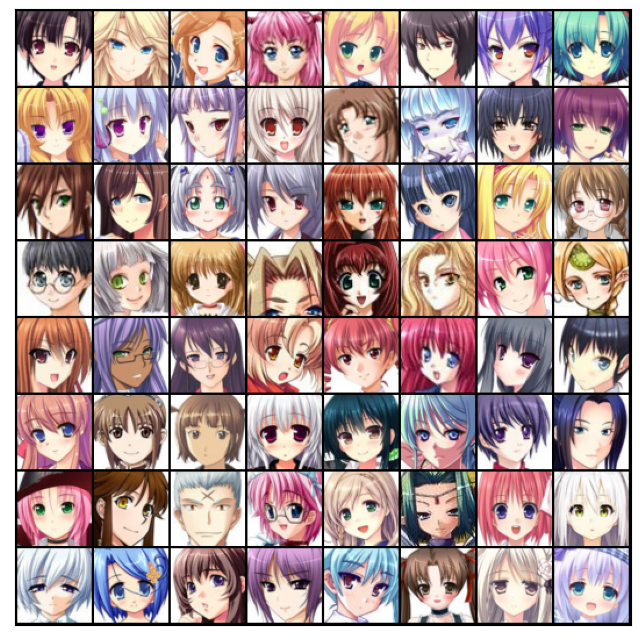

In [11]:
show_batch(train_dl)

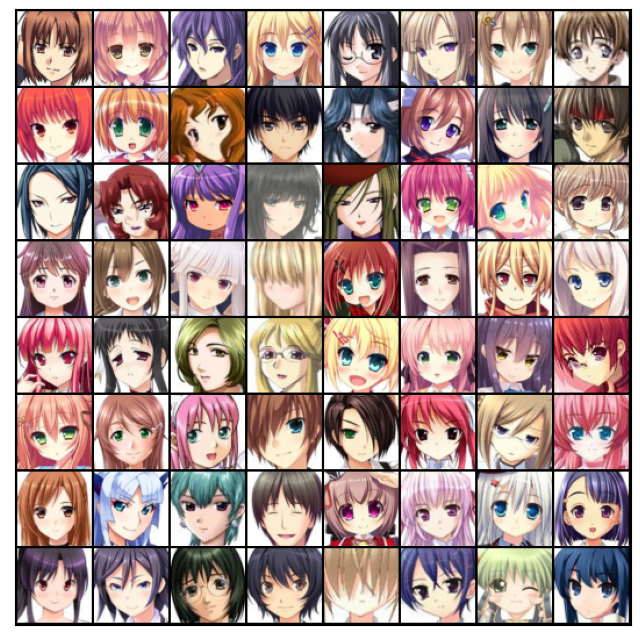

In [12]:
show_batch(val_dl)

In [13]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Linear(1, 1))

In [18]:
# discriminator.load_state_dict(torch.load(f'Dv{version}.pth'))

In [19]:
discriminator = to_device(discriminator, device)

In [20]:
latent_size = 128

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [22]:
# generator.load_state_dict(torch.load(f'Gv{version}.pth'))

In [23]:
generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


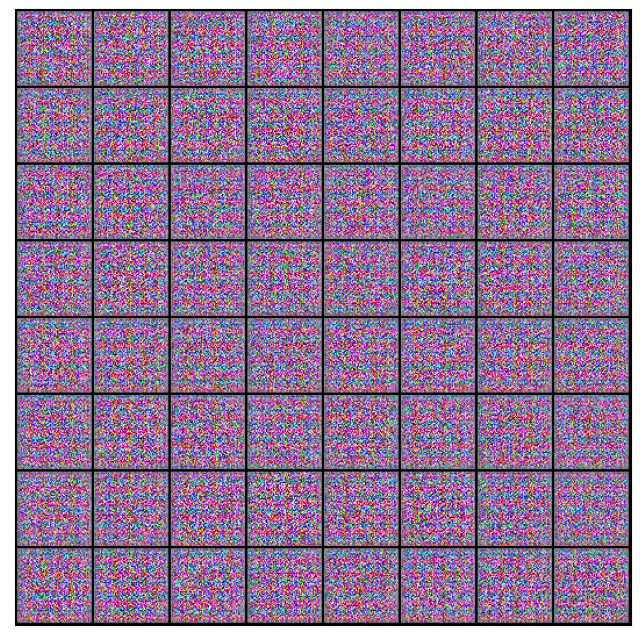

In [24]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device) # random latent tensors
fake_images = generator(fixed_latent)
print(fake_images.shape)
show_images(fake_images.cpu().detach())

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_score = torch.mean(real_preds)
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_score = torch.mean(fake_preds)

    # Update discriminator weights only if loss is greater than threshold
    loss = (-real_score + fake_score) / 2
    loss.backward()
    opt_d.step()
    #loss.item()
    
    return loss.item(), real_score.item(), fake_score.item()

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator with smoothed fake targets
    preds = discriminator(fake_images)
    loss = -torch.mean(preds)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [29]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname, '\n')
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png 



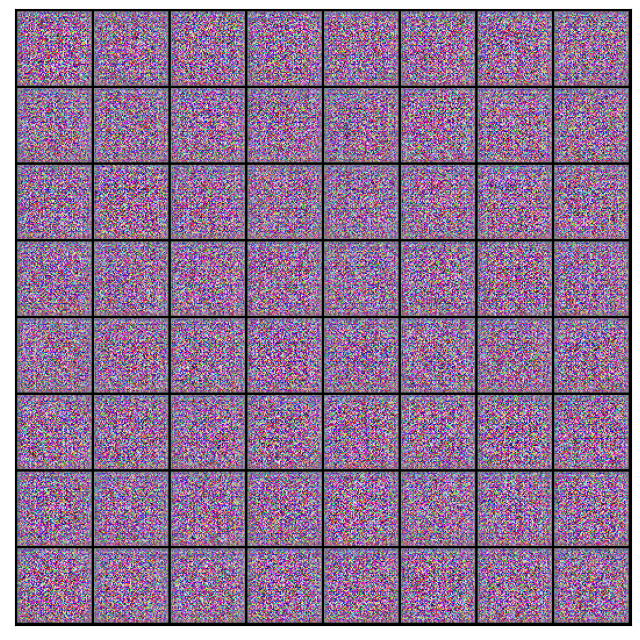

In [31]:
save_samples(0, fixed_latent)

In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [33]:
def fit(epochs, lr, start_idx=1, losses_g=[], losses_d=[], losses_val=[],  real_scores=[], fake_scores=[], val_scores=[], n_critic=1, weight_clip=None):
    torch.cuda.empty_cache()
    # Create optimizers
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    for epoch in range(epochs):
        batch_losses_d, batch_losses_g, batch_real_scores, batch_fake_scores= [], [], [], []        
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            for _ in range(n_critic):
                loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
                if weight_clip:
                    for param in discriminator.parameters():
                        param.data.clamp_(-weight_clip, weight_clip)

            # Train generator
            loss_g = train_generator(opt_g)
       
            batch_losses_g.append(loss_g)
            batch_losses_d.append(loss_d)
            batch_real_scores.append(real_score)
            batch_fake_scores.append(fake_score)
        
        batch_losses_val, batch_val_scores = [], []
        for val_images, _ in val_dl:
            loss_val, val_score, _ = train_discriminator(val_images, opt_d)
            batch_losses_val.append(loss_val)
            batch_val_scores.append(val_score)
            
        # Record losses & scores
        losses_g.extend(batch_losses_g)
        losses_d.extend(batch_losses_d)
        losses_val.extend(batch_losses_val)
        
        real_scores.extend(batch_real_scores)
        fake_scores.extend(batch_fake_scores)
        val_scores.extend(batch_val_scores)
        
        # Calculate epoch scores
        epoch_loss_g = np.mean(losses_g[-len(batch_losses_g):])
        epoch_loss_d = np.mean(losses_d[-len(batch_losses_d):])
        epoch_loss_val = np.mean(losses_val[-len(batch_losses_val):])
        
        epoch_real_score = np.mean(real_scores[-len(batch_real_scores):])
        epoch_fake_score = np.mean(fake_scores[-len(batch_fake_scores):])
        epoch_val_score = np.mean(val_scores[-len(batch_val_scores):])
        
        # Log losses & scores (last batch)
        print(f"Epoch [{ epoch+1}/{epochs}]")
        print(f'Loss_D: {epoch_loss_d:.3f}, Loss_G: {epoch_loss_g:.3f}, Val Loss: {epoch_loss_val:.3f}')
        print(f'Real_Score: {real_score:.3f}, Fake_Score: {fake_score:.3f}, Val Score: {epoch_val_score:.3f}') 
        # Save generated images
        # if (epoch+start_idx) % 10 == 0:
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, losses_val, real_scores, fake_scores, val_scores 

In [34]:
lr = 0.00005
weight_clip = 0.01
n_critic = 2
epochs = 100

In [35]:
history = fit(epochs, lr, n_critic=n_critic, weight_clip=weight_clip)

  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [1/100]
Loss_D: 0.000, Loss_G: 0.010, Val Loss: -0.004
Real_Score: -0.010, Fake_Score: -0.010, Val Score: -0.006
Saving generated-images-0001.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [2/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.020
Real_Score: -0.007, Fake_Score: -0.016, Val Score: 0.010
Saving generated-images-0002.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [3/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.019
Real_Score: -0.006, Fake_Score: -0.015, Val Score: 0.009
Saving generated-images-0003.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [4/100]
Loss_D: -0.005, Loss_G: 0.015, Val Loss: -0.016
Real_Score: -0.004, Fake_Score: -0.015, Val Score: 0.007
Saving generated-images-0004.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [5/100]
Loss_D: -0.005, Loss_G: 0.014, Val Loss: -0.016
Real_Score: -0.006, Fake_Score: -0.016, Val Score: 0.005
Saving generated-images-0005.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [6/100]
Loss_D: -0.005, Loss_G: 0.014, Val Loss: -0.012
Real_Score: -0.004, Fake_Score: -0.010, Val Score: 0.002
Saving generated-images-0006.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [7/100]
Loss_D: -0.005, Loss_G: 0.015, Val Loss: -0.013
Real_Score: -0.009, Fake_Score: -0.015, Val Score: 0.003
Saving generated-images-0007.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [8/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.018
Real_Score: -0.009, Fake_Score: -0.016, Val Score: 0.008
Saving generated-images-0008.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [9/100]
Loss_D: -0.004, Loss_G: 0.013, Val Loss: -0.013
Real_Score: -0.005, Fake_Score: -0.016, Val Score: 0.003
Saving generated-images-0009.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [10/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.013
Real_Score: -0.008, Fake_Score: -0.016, Val Score: 0.003
Saving generated-images-0010.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [11/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.010
Real_Score: -0.005, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0011.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [12/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.010
Real_Score: -0.004, Fake_Score: -0.011, Val Score: -0.000
Saving generated-images-0012.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [13/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.011
Real_Score: -0.005, Fake_Score: -0.015, Val Score: 0.000
Saving generated-images-0013.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [14/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.011
Real_Score: -0.004, Fake_Score: -0.012, Val Score: 0.001
Saving generated-images-0014.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [15/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.013
Real_Score: -0.011, Fake_Score: -0.016, Val Score: 0.003
Saving generated-images-0015.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [16/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.011
Real_Score: -0.005, Fake_Score: -0.014, Val Score: 0.001
Saving generated-images-0016.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [17/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.011
Real_Score: -0.006, Fake_Score: -0.015, Val Score: 0.001
Saving generated-images-0017.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [18/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.010
Real_Score: -0.005, Fake_Score: -0.014, Val Score: 0.000
Saving generated-images-0018.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [19/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.012
Real_Score: -0.010, Fake_Score: -0.016, Val Score: 0.001
Saving generated-images-0019.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [20/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.011
Real_Score: -0.005, Fake_Score: -0.011, Val Score: 0.000
Saving generated-images-0020.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [21/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.010
Real_Score: -0.004, Fake_Score: -0.011, Val Score: 0.000
Saving generated-images-0021.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [22/100]
Loss_D: -0.004, Loss_G: 0.014, Val Loss: -0.010
Real_Score: -0.006, Fake_Score: -0.015, Val Score: 0.001
Saving generated-images-0022.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [23/100]
Loss_D: -0.004, Loss_G: 0.015, Val Loss: -0.010
Real_Score: -0.005, Fake_Score: -0.014, Val Score: -0.000
Saving generated-images-0023.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [24/100]
Loss_D: -0.004, Loss_G: 0.013, Val Loss: -0.010
Real_Score: -0.005, Fake_Score: -0.013, Val Score: 0.000
Saving generated-images-0024.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [25/100]
Loss_D: -0.004, Loss_G: 0.013, Val Loss: -0.009
Real_Score: -0.006, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0025.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [26/100]
Loss_D: -0.004, Loss_G: 0.013, Val Loss: -0.012
Real_Score: -0.010, Fake_Score: -0.016, Val Score: 0.003
Saving generated-images-0026.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [27/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.010
Real_Score: -0.006, Fake_Score: -0.014, Val Score: 0.000
Saving generated-images-0027.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [28/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.009
Real_Score: -0.004, Fake_Score: -0.010, Val Score: -0.000
Saving generated-images-0028.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [29/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.010
Real_Score: -0.005, Fake_Score: -0.012, Val Score: 0.000
Saving generated-images-0029.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [30/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.011
Real_Score: -0.009, Fake_Score: -0.015, Val Score: 0.001
Saving generated-images-0030.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [31/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.009
Real_Score: -0.005, Fake_Score: -0.011, Val Score: -0.001
Saving generated-images-0031.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [32/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.011
Real_Score: -0.009, Fake_Score: -0.015, Val Score: 0.001
Saving generated-images-0032.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [33/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.009
Real_Score: -0.005, Fake_Score: -0.011, Val Score: -0.001
Saving generated-images-0033.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [34/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.010
Real_Score: -0.009, Fake_Score: -0.015, Val Score: -0.000
Saving generated-images-0034.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [35/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.008
Real_Score: -0.005, Fake_Score: -0.011, Val Score: -0.001
Saving generated-images-0035.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [36/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.011
Real_Score: -0.009, Fake_Score: -0.015, Val Score: 0.001
Saving generated-images-0036.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [37/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.010
Real_Score: -0.008, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0037.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [38/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.009
Real_Score: -0.008, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0038.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [39/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.009
Real_Score: -0.005, Fake_Score: -0.012, Val Score: -0.001
Saving generated-images-0039.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [40/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.009
Real_Score: -0.008, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0040.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [41/100]
Loss_D: -0.003, Loss_G: 0.012, Val Loss: -0.009
Real_Score: -0.009, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0041.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [42/100]
Loss_D: -0.003, Loss_G: 0.012, Val Loss: -0.009
Real_Score: -0.008, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0042.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [43/100]
Loss_D: -0.003, Loss_G: 0.011, Val Loss: -0.008
Real_Score: -0.008, Fake_Score: -0.015, Val Score: -0.001
Saving generated-images-0043.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [44/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.010
Real_Score: -0.009, Fake_Score: -0.015, Val Score: -0.000
Saving generated-images-0044.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [45/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.007
Real_Score: -0.005, Fake_Score: -0.011, Val Score: -0.002
Saving generated-images-0045.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [46/100]
Loss_D: -0.003, Loss_G: 0.013, Val Loss: -0.008
Real_Score: -0.008, Fake_Score: -0.014, Val Score: -0.002
Saving generated-images-0046.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [47/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.012
Real_Score: -0.009, Fake_Score: -0.015, Val Score: 0.003
Saving generated-images-0047.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [48/100]
Loss_D: -0.002, Loss_G: 0.009, Val Loss: -0.008
Real_Score: -0.008, Fake_Score: -0.014, Val Score: -0.002
Saving generated-images-0048.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [49/100]
Loss_D: -0.003, Loss_G: 0.014, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.012, Val Score: -0.003
Saving generated-images-0049.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [50/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.008
Real_Score: -0.008, Fake_Score: -0.014, Val Score: -0.002
Saving generated-images-0050.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [51/100]
Loss_D: -0.002, Loss_G: 0.013, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.002
Saving generated-images-0051.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [52/100]
Loss_D: -0.002, Loss_G: 0.013, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.012, Val Score: -0.003
Saving generated-images-0052.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [53/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.002
Saving generated-images-0053.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [54/100]
Loss_D: -0.002, Loss_G: 0.013, Val Loss: -0.007
Real_Score: -0.005, Fake_Score: -0.009, Val Score: -0.002
Saving generated-images-0054.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [55/100]
Loss_D: -0.002, Loss_G: 0.013, Val Loss: -0.008
Real_Score: -0.010, Fake_Score: -0.015, Val Score: -0.002
Saving generated-images-0055.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [56/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.007
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.002
Saving generated-images-0056.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [57/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.008
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.001
Saving generated-images-0057.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [58/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.002
Saving generated-images-0058.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [59/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.008
Real_Score: -0.010, Fake_Score: -0.015, Val Score: -0.002
Saving generated-images-0059.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [60/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.012, Val Score: -0.003
Saving generated-images-0060.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [61/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.008
Real_Score: -0.008, Fake_Score: -0.014, Val Score: -0.002
Saving generated-images-0061.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [62/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.008
Real_Score: -0.008, Fake_Score: -0.014, Val Score: -0.002
Saving generated-images-0062.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [63/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0063.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [64/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.012, Val Score: -0.002
Saving generated-images-0064.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [65/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.008
Real_Score: -0.006, Fake_Score: -0.012, Val Score: -0.002
Saving generated-images-0065.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [66/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0066.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [67/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.008
Real_Score: -0.009, Fake_Score: -0.013, Val Score: -0.002
Saving generated-images-0067.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [68/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0068.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [69/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.008, Fake_Score: -0.014, Val Score: -0.002
Saving generated-images-0069.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [70/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.008
Real_Score: -0.007, Fake_Score: -0.013, Val Score: -0.002
Saving generated-images-0070.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [71/100]
Loss_D: -0.001, Loss_G: 0.010, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.003
Saving generated-images-0071.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [72/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.009, Fake_Score: -0.014, Val Score: -0.003
Saving generated-images-0072.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [73/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.007
Real_Score: -0.007, Fake_Score: -0.012, Val Score: -0.001
Saving generated-images-0073.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [74/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.007, Fake_Score: -0.013, Val Score: -0.002
Saving generated-images-0074.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [75/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.007
Real_Score: -0.005, Fake_Score: -0.009, Val Score: -0.003
Saving generated-images-0075.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [76/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.009
Real_Score: -0.009, Fake_Score: -0.014, Val Score: -0.001
Saving generated-images-0076.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [77/100]
Loss_D: -0.001, Loss_G: 0.009, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.002
Saving generated-images-0077.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [78/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.003
Saving generated-images-0078.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [79/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.009, Val Score: -0.003
Saving generated-images-0079.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [80/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.010
Real_Score: -0.010, Fake_Score: -0.014, Val Score: 0.001
Saving generated-images-0080.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [81/100]
Loss_D: -0.001, Loss_G: 0.008, Val Loss: -0.008
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.002
Saving generated-images-0081.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [82/100]
Loss_D: -0.001, Loss_G: 0.008, Val Loss: -0.007
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0082.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [83/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0083.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [84/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.009, Val Score: -0.003
Saving generated-images-0084.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [85/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.009, Val Score: -0.004
Saving generated-images-0085.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [86/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.003
Saving generated-images-0086.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [87/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.003
Saving generated-images-0087.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [88/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.011, Val Score: -0.004
Saving generated-images-0088.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [89/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.008
Real_Score: -0.010, Fake_Score: -0.014, Val Score: -0.001
Saving generated-images-0089.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [90/100]
Loss_D: -0.001, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0090.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [91/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.012, Val Score: -0.002
Saving generated-images-0091.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [92/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0092.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [93/100]
Loss_D: -0.002, Loss_G: 0.009, Val Loss: -0.007
Real_Score: -0.009, Fake_Score: -0.014, Val Score: -0.003
Saving generated-images-0093.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [94/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.008, Fake_Score: -0.013, Val Score: -0.003
Saving generated-images-0094.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [95/100]
Loss_D: -0.002, Loss_G: 0.011, Val Loss: -0.007
Real_Score: -0.009, Fake_Score: -0.014, Val Score: -0.003
Saving generated-images-0095.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [96/100]
Loss_D: -0.002, Loss_G: 0.012, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.010, Val Score: -0.003
Saving generated-images-0096.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [97/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.006, Fake_Score: -0.010, Val Score: -0.004
Saving generated-images-0097.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [98/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.006
Real_Score: -0.009, Fake_Score: -0.014, Val Score: -0.003
Saving generated-images-0098.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [99/100]
Loss_D: -0.002, Loss_G: 0.010, Val Loss: -0.007
Real_Score: -0.010, Fake_Score: -0.014, Val Score: -0.003
Saving generated-images-0099.png 



  0%|          | 0/398 [00:00<?, ?it/s]

Epoch [100/100]
Loss_D: -0.002, Loss_G: 0.013, Val Loss: -0.006
Real_Score: -0.005, Fake_Score: -0.011, Val Score: -0.003
Saving generated-images-0100.png 



In [36]:
losses_g, losses_d, losses_val, real_scores, fake_scores, val_scores = history

In [37]:
# history = fit(1000, lr, start_idx=401, losses_g=losses_g, losses_d=losses_d, losses_val=losses_val, real_scores=real_scores, fake_scores=fake_scores, val_scores=val_scores, weight_clip=weight_clip)
# losses_g, losses_d, losses_val, real_scores, fake_scores, val_scores = history

In [38]:
import pandas as pd
def plot_results(dist1, dist2, title, window_size1=len(train_dl), window_size2=len(train_dl)):
    x1 = np.arange(0, len(dist1), 1)
    x2 = np.arange(0, len(dist2), 1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Calculate the rolling means for each distribution
    rolling_mean1 = pd.Series(dist1).rolling(window=window_size1).mean()
    rolling_mean2 = pd.Series(dist2).rolling(window=window_size2).mean()
    
    # Plot the distributions with shading between rolling means
    ax.fill_between(x1, dist1, rolling_mean1, alpha=0.3, label='Real', color='blue')
    ax.fill_between(x2, dist2, rolling_mean2, alpha=0.3, label='Fake', color='orange')

    # Plot the rolling means as lines
    ax.plot(x1, rolling_mean1, label='Moving Mean Real', color='blue')
    ax.plot(x2, rolling_mean2, label='Moving Mean Fake', color='orange')

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()    

In [39]:
# plot_results(real_scores, val_scores, 'Real Scores vs Val Scores', window_size1=len(train_dl), window_size2=len(val_dl))

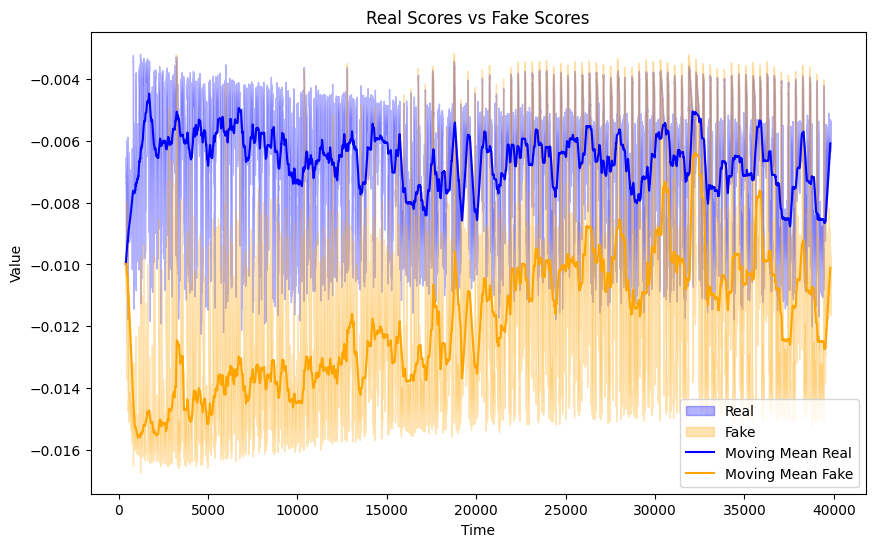

In [40]:
plot_results(real_scores, fake_scores, 'Real Scores vs Fake Scores')

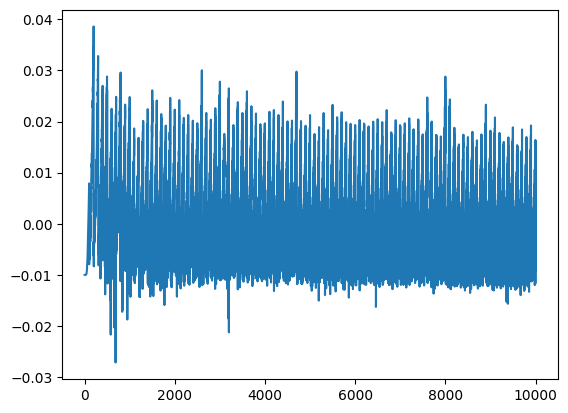

In [41]:
plt.plot(val_scores)

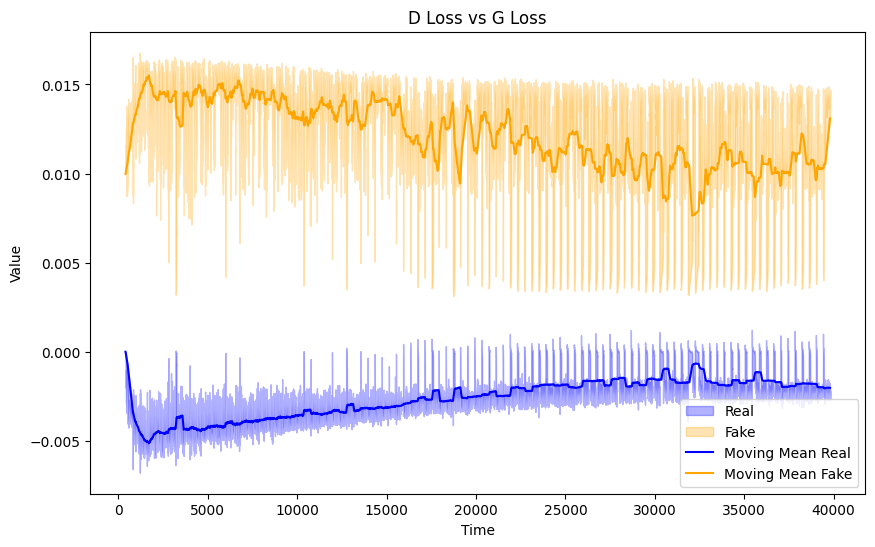

In [42]:
plot_results(losses_d, losses_g, 'D Loss vs G Loss')

In [43]:
# Save the model checkpoints 
torch.save(generator.state_dict(), f'Gv{version}.pth')
torch.save(discriminator.state_dict(), f'Dv{version}.pth')

In [44]:
import cv2
import os

vid_fname = f'gans_training_v{version}.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [45]:
from IPython.display import Image

In [46]:
# Image('./generated/generated-images-0001.png')

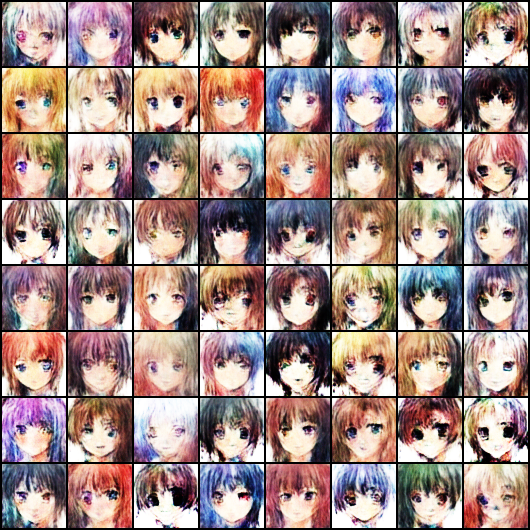

In [47]:
Image('./generated/generated-images-0010.png')

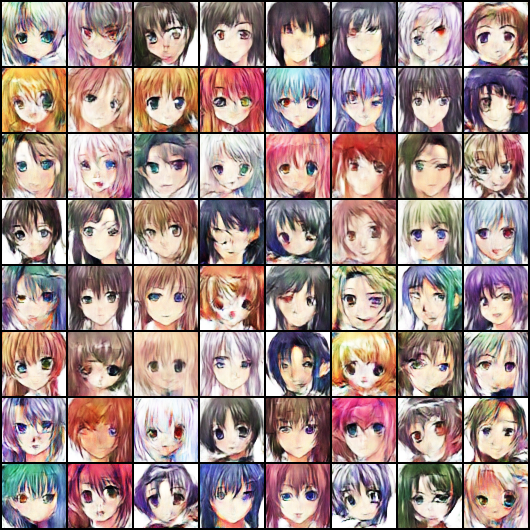

In [48]:
Image('./generated/generated-images-0100.png')

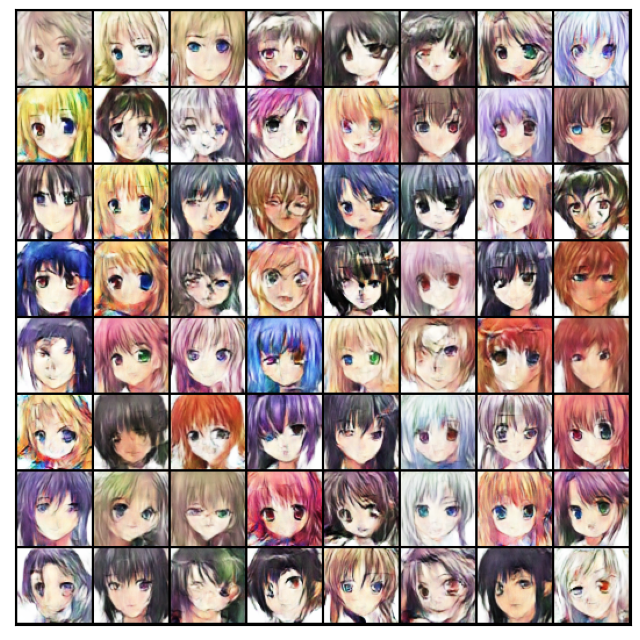

In [49]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

tensor([[-0.0408]], device='cuda:0', grad_fn=<AddmmBackward0>)


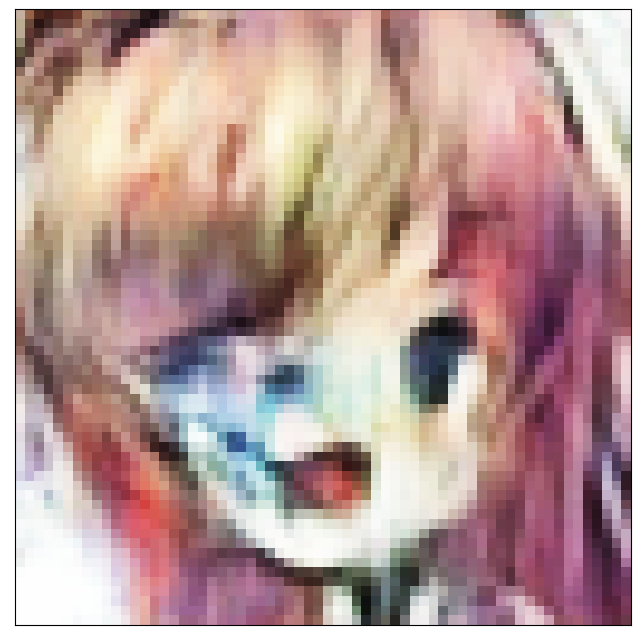

In [50]:
torch.manual_seed(0)
new_latent = torch.randn(1, latent_size, 1, 1, device=device)
fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
print(discriminator(generator(new_latent)))

tensor([[-0.0427]], device='cuda:0', grad_fn=<AddmmBackward0>)


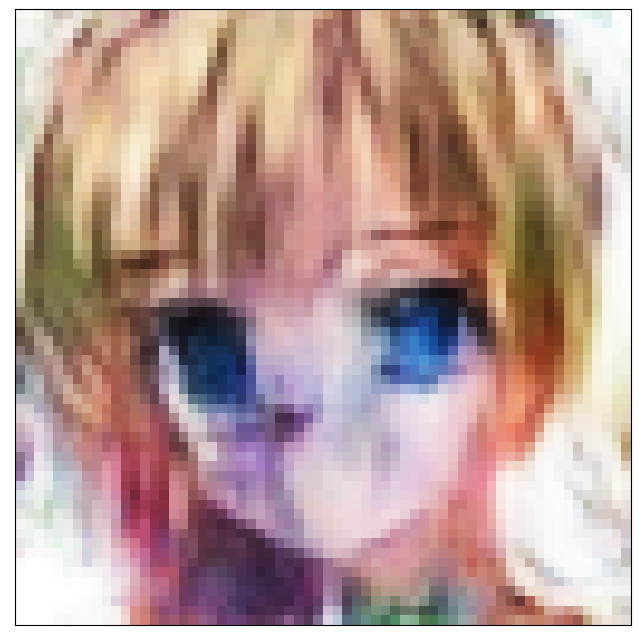

In [51]:
torch.manual_seed(0)
new_latent = torch.randn(1, latent_size, 1, 1, device=device) + 555
fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
print(discriminator(generator(new_latent)))